In [1]:

"""
Gabor orientation 2AFC (clockwise vs counterclockwise) -- PyTorch implementation.

Requirements:
  - Python 3.8+
  - torch
  - torchvision (optional)
  - numpy
  - matplotlib

Run:
  python gabor_2afc_mlp.py
"""

import math
import numpy as np
import random
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [2]:


# ---------- Gabor generator ----------
def make_gabor(size=64, orientation_deg=0.0, spatial_freq=0.08, sigma=10.0, phase=0.0, contrast=1.0):
    """
    Generate a single Gabor patch (grayscale) as numpy float32 array in [-1, 1].
    size: image size (size x size)
    orientation_deg: orientation in degrees (0 = vertical grating)
    spatial_freq: cycles per pixel (e.g., 0.08)
    sigma: gaussian envelope sigma (pixels)
    phase: phase offset (radians)
    contrast: multiply sinusoid amplitude
    """
    # coordinates centered
    xs = np.linspace(-size//2, size//2 - 1, size)
    ys = np.linspace(-size//2, size//2 - 1, size)
    xv, yv = np.meshgrid(xs, ys)
    theta = math.radians(orientation_deg)
    # rotate coordinates
    xr = xv * math.cos(theta) + yv * math.sin(theta)
    # sinusoidal grating
    sinusoid = np.cos(2.0 * np.pi * spatial_freq * xr + phase)
    # gaussian envelope
    gauss = np.exp(-(xv**2 + yv**2) / (2.0 * (sigma**2)))
    img = contrast * sinusoid * gauss
    # normalize to [-1, 1] roughly (gauss peak = 1)
    max_abs = np.max(np.abs(img)) + 1e-9
    img = img / max_abs
    return img.astype(np.float32)

# ---------- Dataset ----------
class Gabor2AFCDataset(Dataset):
    def __init__(self, n_samples=10000, size=64, angle_offset=5.0, noise_std=0.2, 
                 spatial_freq=0.08, sigma=10.0, randomize_angles=True):
        """
        angle_offset: degrees offset from reference (0 deg). 
          label 1 = clockwise (orientation > 0), label 0 = counterclockwise (orientation < 0)
        """
        self.n = n_samples
        self.size = size
        self.angle_offset = angle_offset
        self.noise_std = noise_std
        self.spatial_freq = spatial_freq
        self.sigma = sigma
        self.randomize = randomize_angles

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        # sample label randomly 0/1
        label = np.random.randint(0, 2)
        # base angle is +offset or -offset (around 0)
        sign = 1 if label == 1 else -1
        angle = sign * self.angle_offset
        # optional small jitter on angle to avoid overfitting to exact degrees
        if self.randomize:
            angle += np.random.normal(scale=0.5)
        img = make_gabor(size=self.size, orientation_deg=angle, spatial_freq=self.spatial_freq, sigma=self.sigma)
        # add gaussian pixel noise
        img = img + np.random.normal(scale=self.noise_std, size=img.shape).astype(np.float32)
        # clip
        img = np.clip(img, -1.0, 1.0)
        # to tensor
        tensor = torch.from_numpy(img).unsqueeze(0)  # 1 x H x W
        return tensor, torch.tensor(label, dtype=torch.long)


In [3]:
# ---------- Psychometric curve ----------
def psychometric_curve(model, device, angles, samples_per_angle=200, size=64, noise_std=0.2, spatial_freq=0.08, sigma=10.0):
    probs = []
    with torch.no_grad():
        for ang in angles:
            # ang is positive for clockwise, negative for counterclockwise
            # We create images with orientation = ang, and ask model's prob(label=1)
            X = []
            for i in range(samples_per_angle):
                img = make_gabor(size=size, orientation_deg=ang, spatial_freq=spatial_freq, sigma=sigma)
                img = img + np.random.normal(scale=noise_std, size=img.shape).astype(np.float32)
                img = np.clip(img, -1.0, 1.0)
                X.append(img)
            X = np.stack(X)  # N x H x W
            X = torch.from_numpy(X).unsqueeze(1).to(device)  # N x 1 x H x W
            logits = model.forward(X.view(-1,X.shape[1] * X.shape[2] * X.shape[3]))
            probs_clockwise = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
            probs_clockwise = logits[:,1].cpu().numpy()
            probs.append(probs_clockwise.mean())
    return np.array(probs), logits

In [ ]:
import sys
from models_LN import FNN_LN, FRNN_LN, dataset, one_hot, cross_entropy_loss, linear_d, tanh, tanh_d, sign, sign_d, sigmoid, sigmoid_d, relu, relu_d, relu6, relu6_d, softmax


# 
class Config:
    def __init__(self):
        self.device = device
        self.n_input = 28 * 28  # input size
        self.n_out = 10         # number of classes

        self.nL_hidd = 2        # num of hidden layers
        self.n_hidd = 256      # hidden layers

        self.n_NperU = 64      # num of nodes per unit per layer
        self.n_NU = self.n_hidd // self.n_NperU 

        self.f = tanh          # f tanh relu6 relu
        self.fd = tanh_d

        self.RNN_CR = 1      # RNN connection rate
        self.RNN_SR = 0.25    # Maximum singular value of RNN weights
        self.RNN_t2sta = 8      # The number of iterations to stability
        self.RNN_t2sta2 = self.RNN_t2sta//2
        self.flag_ycz = True
        
        self.sc_forward = 1      # Feedforward scaling
        self.sc_forward_f = 1
        self.sc_back = np.sqrt(self.n_NperU)/1        # Feedback scaling
        self.sc_back_f = 1
        self.sc_bias = 1.0        # RNN bias scaling

        self.factor_beta1 = 1   # feedback error factor 

        self.flag_feedbackLearning = False # wheather the feedback weights are updated
        self.factor_gamma1 = 1e-3      # the factor of feedback weights updated : 0< 1e-3  <0.1

        self.flag_RNNLearning = True        # wheather the RNN weights are updated
        self.flag_RNNBiasLearning = False    # wheather the RNN bias are updated

        self.train_n_epochs = 20      # Training epochs
        self.train_batch_size = 200     # batch size
        self.train_eta_global = 2e-2    # learning rate
        self.train_fbupdaterule = 'ee'
        self.RNN_alpha1 = 1e-4          # the factor of RNN weights updated
        self.train_lambda1 = 0e-6       # L2 regularization
        self.train_task = "FMNIST"     #  "MNIST" "FMNIST" "CIFAR10"
        self.train_tmethod = 'AP'         # 'AP', 'FA'

        self.PC_gamma = 1       # PC x update 
        self.FA_nonlinearRNN_flag = False
        self.fb_feedbacknum = -1


config = Config()

def model_train_eval_AP(train_loader_gpu, test_loader_gpu, multitest = 1, taskinfo=''):
    res = np.zeros((multitest,3,config.train_n_epochs))
    for  imultitest in range(multitest):
        config.sc_back_f = config.RNN_SR if config.n_NU ==1 else 1
        config.sc_back = config.sc_back_f if config.n_NU ==1 else np.sqrt(config.n_NperU)/1
        #
        model = FRNN_LN(config).to(device)

        # taskinfo = f'FRNN_L{config.nL_hidd}_{config.train_task}'
        # print(taskinfo)

        ###### Train #######
        for epoch in range(config.train_n_epochs):
            losssum = 0
            # random.shuffle(train_loader_gpu)
            for i, (images, labels) in enumerate(train_loader_gpu):
                # data processing
                images = images.view(-1, config.n_input)
                labels_one_hot = one_hot(labels, config.n_out)

                # forward
                outputs = model.forward(images)

                # Calculate loss (cross entropy)
                loss = cross_entropy_loss(outputs, labels_one_hot.to(device))
                loss = loss.to('cpu')
                losssum += loss.item()
                # backp
                outputs = model.backward(images, labels_one_hot, outputs)

                # Update weights
                model.update_weights_adam() #update_weights_adam


            train_correct = 0
            train_total = 0
            losssum = 0
            with torch.no_grad():
                for images, labels in train_loader_gpu:
                    images = images.view(-1, config.n_input)
                    labels_one_hot = one_hot(labels, config.n_out)
                    outputs = model.forward(images)

                    _, predicted = torch.max(outputs, 1)
                    # predicted = predicted.to('cpu')
                    loss = cross_entropy_loss(outputs, labels_one_hot.to(device))
                    loss = loss.to('cpu')
                    losssum += loss.item()
                    train_total += labels.size(0)
                    train_correct += (predicted.to('cpu') == labels).sum().item()

            train_accuracy = train_correct / train_total

            test_correct = 0
            test_total = 0
            y_true = []
            y_pred = []
            with torch.no_grad():
                for images, labels in test_loader_gpu:
                    images = images.view(-1, config.n_input)
                    outputs = model.forward(images)

                    _, predicted = torch.max(outputs, 1)
                    # predicted = predicted.to('cpu')
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(predicted.cpu().numpy())
                    test_total += labels.size(0)
                    test_correct += (predicted.to('cpu') == labels).sum().item()

            test_accuracy = test_correct / test_total

            res[imultitest][0][epoch] = losssum
            res[imultitest][1][epoch] = train_accuracy
            res[imultitest][2][epoch] = test_accuracy
            print(f'Epoch {epoch:5d}\t Loss: {res[imultitest][0][epoch] :7.3f}, '
                    f'Train : {res[imultitest][1][epoch] * 100:6.2f}%, '
                    f'Test : {res[imultitest][2][epoch] * 100:6.2f}%, ')
    return res, model

In [5]:
# ---------- Main experiment ----------


noise_level = [0.0,0.2,1,2,4] #0.0,0.1,0.25,0.5,1,2,4 0.0,0.05,0.3,1,4

imgs,probs = [],[]
resAP = []
# Psychometric curve: sweep angles from -12 to +12 degrees
angles = np.linspace(-12.0, 12.0, 25)

for ia in range(len(noise_level)):

    Noise_std = noise_level[ia]
    Spatial_freq=0.15

    # dataset params
    img_size = 32
    train_ds = Gabor2AFCDataset(n_samples=400, size=img_size, angle_offset=6.0, noise_std=Noise_std, spatial_freq=Spatial_freq, )
    val_ds = Gabor2AFCDataset(n_samples=100, size=img_size, angle_offset=6.0, noise_std=Noise_std, spatial_freq=Spatial_freq, )
    train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)

    img, label = train_ds[0]
    img_np = img.squeeze(0).numpy()  # 
    imgs.append(img_np)
    

    config.n_input = img_size * img_size

    # training loop
    config.train_n_epochs = 20
    print(f"NOISE:{Noise_std}")
    res, model = model_train_eval_AP(train_loader, val_loader, multitest = 5)

    resAP.append(res)
    p, logits = psychometric_curve(model, device, angles, samples_per_angle=100, size=img_size, noise_std=Noise_std, spatial_freq=Spatial_freq)
    probs.append(p)

    

NOISE:0.0
Epoch     0	 Loss:   1.014, Train : 100.00%, Test : 100.00%, 
Epoch     1	 Loss:   0.336, Train : 100.00%, Test : 100.00%, 
Epoch     2	 Loss:   0.172, Train : 100.00%, Test : 100.00%, 
Epoch     3	 Loss:   0.102, Train : 100.00%, Test : 100.00%, 
Epoch     4	 Loss:   0.062, Train : 100.00%, Test : 100.00%, 
Epoch     5	 Loss:   0.043, Train : 100.00%, Test : 100.00%, 
Epoch     6	 Loss:   0.031, Train : 100.00%, Test : 100.00%, 
Epoch     7	 Loss:   0.024, Train : 100.00%, Test : 100.00%, 
Epoch     8	 Loss:   0.019, Train : 100.00%, Test : 100.00%, 
Epoch     9	 Loss:   0.015, Train : 100.00%, Test : 100.00%, 
Epoch    10	 Loss:   0.011, Train : 100.00%, Test : 100.00%, 
Epoch    11	 Loss:   0.009, Train : 100.00%, Test : 100.00%, 
Epoch    12	 Loss:   0.009, Train : 100.00%, Test : 100.00%, 
Epoch    13	 Loss:   0.008, Train : 100.00%, Test : 100.00%, 
Epoch    14	 Loss:   0.007, Train : 100.00%, Test : 100.00%, 
Epoch    15	 Loss:   0.006, Train : 100.00%, Test : 100.00%,

[[[[1.01437629e+00 3.35679795e-01 1.71991348e-01 ... 6.54703163e-03
    4.69425266e-03 3.95073842e-03]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
    1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
    1.00000000e+00 1.00000000e+00]]

  [[2.69172167e+00 7.68764392e-01 3.59933357e-01 ... 2.63321207e-02
    1.43154311e-02 1.65583959e-02]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
    1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
    1.00000000e+00 1.00000000e+00]]

  [[1.45852870e+00 4.98171449e-01 2.55568255e-01 ... 6.65336484e-03
    8.44965201e-03 6.97523694e-03]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
    1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
    1.00000000e+00 1.00000000e+00]]

  [[1.12835415e+00 3.74653582e-01 1.87656946e-01 ... 7.97804657e-03

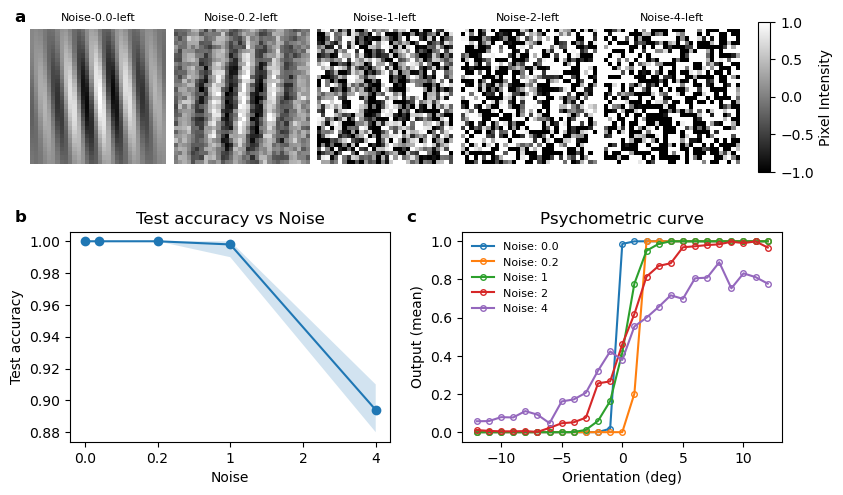

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(8,5))

# ----------------  ----------------
images_positions = [
  [0.03, 0.55, 0.1693, 0.40],
  [0.2093, 0.55, 0.1693, 0.40],
  [0.3887, 0.55, 0.1693, 0.40],
  [0.568, 0.55, 0.1693, 0.40],
  [0.7473, 0.55, 0.1693, 0.40],
]
fig.text(0.01, 0.9, 'a', fontsize=12, fontweight='bold')
fig.text(0.01, 0.5, 'b', fontsize=12, fontweight='bold')
fig.text(0.5, 0.5, 'c', fontsize=12, fontweight='bold')
cbar_pos = [0.94, 0.6, 0.015, 0.3]

axes_imgs = []
for pos, img, Noise_std in zip(images_positions, imgs, noise_level):
    ax = fig.add_axes(pos)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Noise-{Noise_std}-{'right' if label.item() else 'left'}", fontsize=8)
    ax.axis('off')
    axes_imgs.append(ax)

#  colorbar
all_imgs = np.stack(imgs)
vmin, vmax = all_imgs.min(), all_imgs.max()
for ax in axes_imgs:
    ax.images[0].set_clim(vmin, vmax)

cax = fig.add_axes(cbar_pos)
fig.colorbar(axes_imgs[-1].images[0], cax=cax, orientation='vertical').set_label('Pixel Intensity')

# ---------------- ----------------
bottom_left_pos  = [0.57, 0.06, 0.40, 0.42]
bottom_right_pos = [0.08, 0.06, 0.40, 0.42]

axL = fig.add_axes(bottom_left_pos)
axR = fig.add_axes(bottom_right_pos)

# psychometric curve
for ia in range(len(noise_level)):
    axL.plot(angles, probs[ia], marker='o', label=f'Noise: {noise_level[ia]}',
             markerfacecolor='none', markersize=4, markeredgewidth=1)
axL.set_ylim([-0.05,1.05])
axL.set_xlabel('Orientation (deg)')
axL.set_ylabel('Output (mean)')
axL.set_title('Psychometric curve')
axL.legend(frameon=False, fontsize=8)

print(np.array(resAP))
# error vs noise
resAPp = np.array(resAP)
yvals = np.mean(np.max(resAPp[:,:,2,:], axis=-1), axis=1)
ymin = np.min(np.max(resAPp[:,:,2,:], axis=-1), axis=1)
ymax = np.max(np.max(resAPp[:,:,2,:], axis=-1), axis=1)

axR.plot(noise_level, yvals, marker='o')
axR.fill_between(noise_level, ymin, ymax, alpha=0.2)
axR.set_xlabel('Noise')
axR.set_xticks(range(len(noise_level)),noise_level)
axR.set_ylabel('Test accuracy')
axR.set_title('Test accuracy vs Noise')

# plt.savefig("combined_plot.svg", format="svg", dpi=300)
plt.show()